In [69]:
! pip install lazypredict

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
import lazypredict
from lazypredict.Supervised import LazyRegressor

from random import randint

import pickle

## Pubchem Fingerprints

The earlier Lipinski Descriptors give an overview of how drug-like a molecule is, showing how suitable a substance could be for oral consumption.The simplicity of these descriptors makes them appropriate to conduct exploratory data analysis with. Pubchem fingerprints, on the other hand, can give a more microscopic view of chemicals, as they have hundreds of descriptors for each indiividual molecule in a protein, making them ideal for ML models to learn from. However, Generating the Pubchem fingerprints required the Lipinksi Descriptors

In [71]:
# Extract Datasets containing fingerprints
df_protease = pd.read_csv('protease_pubchem_fp.csv')
df_kat5 = pd.read_csv('kat5_pubchem_fp.csv')
df_ccr5 = pd.read_csv('ccr5_pubchem_fp.csv')

## CCR Fingerprints

In [72]:
# Extract input features
X_ccr5 = df_ccr5.drop('pIC50', axis=1)
X_ccr5

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2957,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2958,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2959,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Extract output features
Y_ccr5 = df_ccr5.pIC50
Y_ccr5

0      6.47
1      7.55
2      8.00
3      7.46
4      7.82
       ... 
2956   8.60
2957   8.08
2958   7.80
2959   8.10
2960   7.72
Name: pIC50, Length: 2961, dtype: float64

In [74]:
# Check X Dimension
X_ccr5.shape

(2961, 881)

In [75]:
# Check Y Dimension
Y_ccr5.shape

(2961,)

In [76]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_ccr5 = selection.fit_transform(X_ccr5)

In [77]:
# Check X Dimension after the removal of low variance features
X_ccr5.shape

(2961, 154)

In [78]:
# Split the model into 80-20 format
X_ccr5_train, X_ccr5_test, Y_ccr5_train, Y_ccr5_test = train_test_split(X_ccr5, Y_ccr5, 
                                                                        test_size=0.2, random_state=42)

In [79]:
# Check Training Dimension
X_ccr5_train.shape, Y_ccr5_train.shape

((2368, 154), (2368,))

In [80]:
# Check Testing Dimension
X_ccr5_test.shape, Y_ccr5_test.shape

((593, 154), (593,))

In [81]:
# These Regressors were removed because of other regressors tend to do better on datasets like ours, with a
# sparesely populated feature set (X data)

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "QuantileRegressor", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor", 
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]

# Lazy Regressor will run and hyptertune 39 different regression models from sklearn and compare their
# r_squared and root-mean-square deviation (RMSE) values
clf = LazyRegressor(custom_metric=None, verbose=1, ignore_warnings=False, regressors = REGRESSORS)

In [82]:
# Run the training and testing sets through the lazypredict to find the best regression model
models_ccr5, predictions_ccr5 = clf.fit(X_ccr5_train, X_ccr5_test, Y_ccr5_train, Y_ccr5_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)
 10%|█         | 4/39 [00:01<00:10,  3.25it/s]{'Model': 'BayesianRidge', 'R-Squared': 0.43467671079297476, 'Adjusted R-Squared': 0.23591007486173765, 'RMSE': 1.0767899294017755, 'Time taken': 0.2732124328613281}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5178790817273122, 'Adjusted R-Squared': 0.3483662474487873, 'RMSE': 0.9943986686009023, 'Time taken': 0.1458733081817627}
 15%|█▌        | 6/39 [00:01<00:05,  5.61it/s]{'Model': 'DummyRegressor', 'R-Squared': -0.007532435274105964, 'Adjusted R-Squared': -0.36177899927459056, 'RMSE': 1.4375139395074146, 'Time taken': 0.05046677589416504}
{'Model': 'ElasticNet', 'R-Squared': 0.032900296411533136, 'Adjusted R-Squared': -0.307130192978019, 'RMSE': 1.408374560222409, 'Time taken': 0.07589101791381836}
 26%|██▌       | 10/39 [00:15<00:56,  1.94s/it]{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.5354857840306784, 'Adjusted R-Squared': 0.3721634341236566, 'RMSE': 0.9760724

In [83]:
# Performance table of the test set (20% subset) based on training data (80% subset)
predictions_ccr5 = predictions_ccr5[['R-Squared', 'RMSE']]
predictions_ccr5

,R-Squared,RMSE
Model,,
RandomForestRegressor,0.61,0.89
HistGradientBoostingRegressor,0.61,0.90
SVR,0.61,0.90
MLPRegressor,0.61,0.90
NuSVR,0.60,0.90
BaggingRegressor,0.59,0.92
KNeighborsRegressor,0.59,0.92
GradientBoostingRegressor,0.56,0.95
ExtraTreesRegressor,0.54,0.98


(0.0, 1.0)

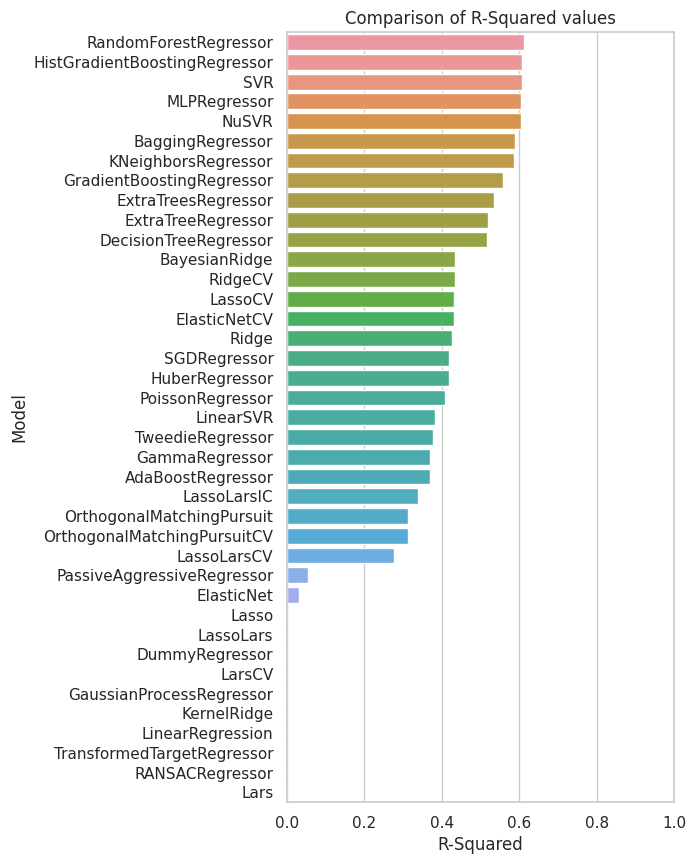

In [84]:
# Bar plot of R-squared values
# train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
sns.barplot(y=predictions_ccr5.index, x="R-Squared", data=predictions_ccr5)
plt.title("Comparison of R-Squared values")
plt.xlim(0, 1)

(0.0, 10.0)

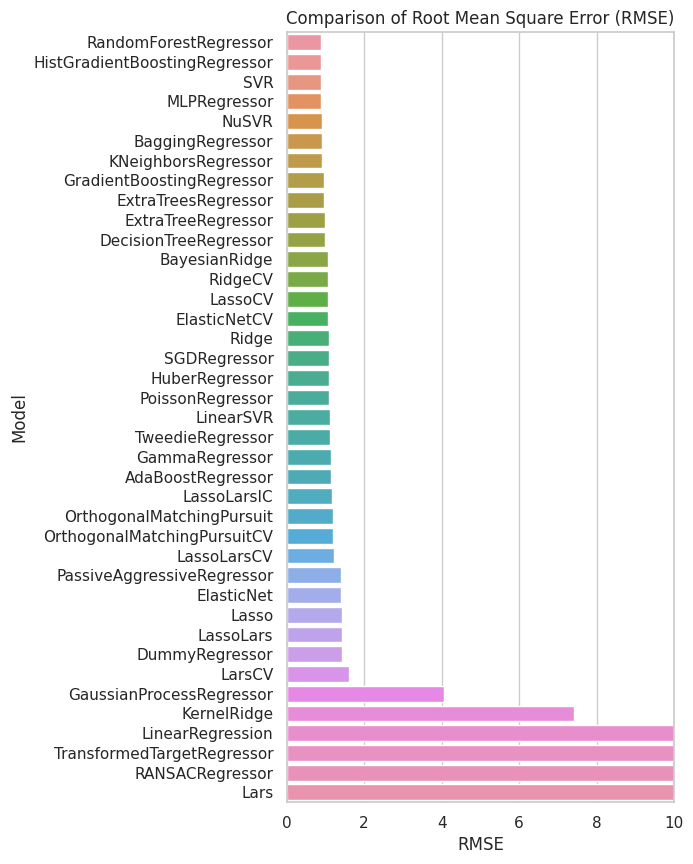

In [114]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
sns.barplot(y=predictions_ccr5.index, x="RMSE", data=predictions_ccr5)
plt.title("Comparison of Root Mean Square Error (RMSE)")
plt.xlim(0, 10)

In [89]:
# Build the Regression Model based on the one with best overall performance (finetuning best model from above)
np.random.seed(100)
random_forest = RandomForestRegressor()

param_distributions = {"max_depth": [6, 5, 4, 3, None], "min_samples_split": [num for num in range(2, 11)]}
search_ccr5 = HalvingRandomSearchCV(random_forest, param_distributions, scoring = "r2").fit(X_ccr5_train, Y_ccr5_train)
search_ccr5.best_params_

{'min_samples_split': 2, 'max_depth': 4}

In [93]:
# Find the r2 value using our hyperparamater-tuned model
r2_ccr5 = search_ccr5.score(X_ccr5_test, Y_ccr5_test)
r2_ccr5

0.471295228753164

We took the best R squared value out of the lazy regressor and our own hyperparameter-tuned models. Lazy Regressor tunes hyperparameters differently than a GridSearch, so we thought trying both methods would yield the best model. In the case of CCR5, the lazy regressor RandomForestRegressor achieved an R sqaured value of 0.6118055618, whearas own our own RandomForestRegressor only achieve an R squared of 0.471295228753164. Thus, we will use Lazy Regressor's model to predict how effect a given chemical is at inhibiting CCR5 in our website.

In [94]:
# Get prediction values from the test dataset
Y_ccr5_pred = search_ccr5.predict(X_ccr5_test)

<function matplotlib.pyplot.show(close=None, block=None)>

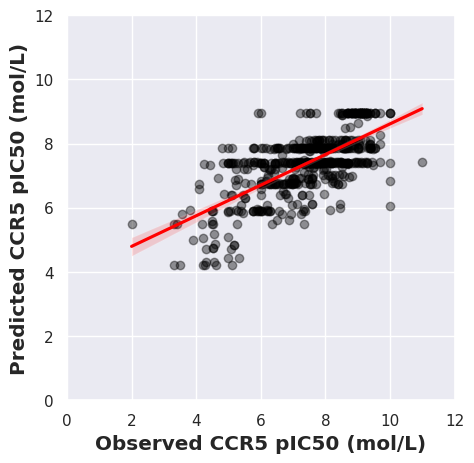

In [95]:
# Scatter Plot of Observed vs Predicted pIC50 Values
sns.set(color_codes=True)
sns.set_style("darkgrid")

ax = sns.regplot(x=Y_ccr5_test, y=Y_ccr5_pred, scatter_kws={'alpha':0.4, "color": "black"}, line_kws={"color": "red"})
ax.set_xlabel('Observed CCR5 pIC50 (mol/L)', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted CCR5 pIC50 (mol/L)', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

In [96]:
# Save model as pickle file, to be used in the website
pickle.dump(search_ccr5.best_estimator_, open('CCR5_model.pkl', 'wb'))

## KAT5 Fingerprints

In [97]:
# Extract input features
X_kat5 = df_kat5.drop('pIC50', axis=1)
X_kat5

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Extract output features
Y_kat5 = df_kat5.pIC50
Y_kat5

0    9.00
1    8.69
2    9.22
3    9.22
4    9.54
5    8.85
6    8.89
7    8.87
8    8.38
9    8.28
10   8.54
11   8.48
12   8.59
13   8.42
14   8.67
15   8.44
16   9.05
17   9.02
18   8.52
19   9.30
20   9.17
21   9.04
22   8.31
23   9.06
24   8.23
25   9.22
26   9.36
27   9.33
28   9.29
29   9.03
30   8.97
31   9.00
32   9.24
33   9.25
34   9.47
35   9.21
36   9.08
37   9.33
38   9.21
39   9.43
40   9.19
41   9.29
42   8.97
43   9.24
Name: pIC50, dtype: float64

In [99]:
# Check X Dimension
X_kat5.shape

(44, 881)

In [100]:
# Check Y Dimension
Y_kat5.shape

(44,)

In [101]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_kat5 = selection.fit_transform(X_kat5)

In [102]:
# Check X Dimension after the removal of low variance features
X_kat5.shape

(44, 97)

In [103]:
# Split the model into 80-20 format
X_kat5_train, X_kat5_test, Y_kat5_train, Y_kat5_test = train_test_split(X_kat5, Y_kat5, 
                                                                        test_size=0.2, random_state=42)

In [104]:
# Check Training Dimension
X_kat5_train.shape, Y_kat5_train.shape

((35, 97), (35,))

In [105]:
# Check Testing Dimension
X_kat5_test.shape, Y_kat5_test.shape

((9, 97), (9,))

In [106]:
# Run the training and testing sets through the lazypredict to find the best regression model
models_kat5, predictions_kat5 = clf.fit(X_kat5_train, X_kat5_test, Y_kat5_train, Y_kat5_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)
  5%|▌         | 2/39 [00:00<00:02, 15.96it/s]{'Model': 'AdaBoostRegressor', 'R-Squared': 0.23256736092589747, 'Adjusted R-Squared': 1.0689827091302564, 'RMSE': 0.39688259358166117, 'Time taken': 0.09580755233764648}
{'Model': 'BaggingRegressor', 'R-Squared': 0.38336647792009737, 'Adjusted R-Squared': 1.055427732321789, 'RMSE': 0.3557586631349609, 'Time taken': 0.029325485229492188}
{'Model': 'BayesianRidge', 'R-Squared': 0.18735402034574133, 'Adjusted R-Squared': 1.0730468296318434, 'RMSE': 0.40840647107096073, 'Time taken': 0.039206504821777344}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.04568243456292642, 'Adjusted R-Squared': 1.0857813541965908, 'RMSE': 0.442576528549546, 'Time taken': 0.019577503204345703}
 13%|█▎        | 5/39 [00:00<00:01, 18.70it/s]{'Model': 'DummyRegressor', 'R-Squared': -0.006586014222420555, 'Adjusted R-Squared': 1.090479641727858, 'RMSE': 0.4545350364372182, 'Time taken': 0.0877165794372

In [107]:
# Performance table of the test set (20% subset) based on training data (80% subset)
predictions_kat5 = predictions_kat5.iloc[::-1][['R-Squared', 'RMSE']]
# R-squared values less than 1 will not be graphed
predictions_kat5

,R-Squared,RMSE
Model,,
LassoCV,0.40,0.35
BaggingRegressor,0.38,0.36
ElasticNetCV,0.38,0.36
OrthogonalMatchingPursuit,0.38,0.36
LassoLarsCV,0.31,0.38
KNeighborsRegressor,0.30,0.38
RandomForestRegressor,0.25,0.39
AdaBoostRegressor,0.23,0.40
LarsCV,0.20,0.41


(0.0, 1.0)

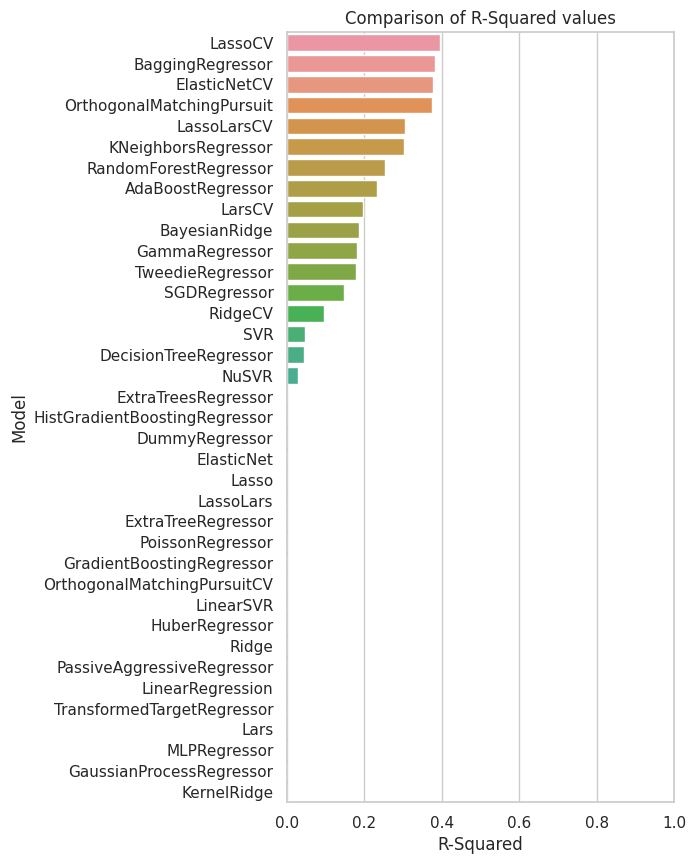

In [108]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
sns.barplot(y=predictions_kat5.index, x="R-Squared", data=predictions_kat5)
plt.title("Comparison of R-Squared values")
plt.xlim(0, 1)

(0.0, 10.0)

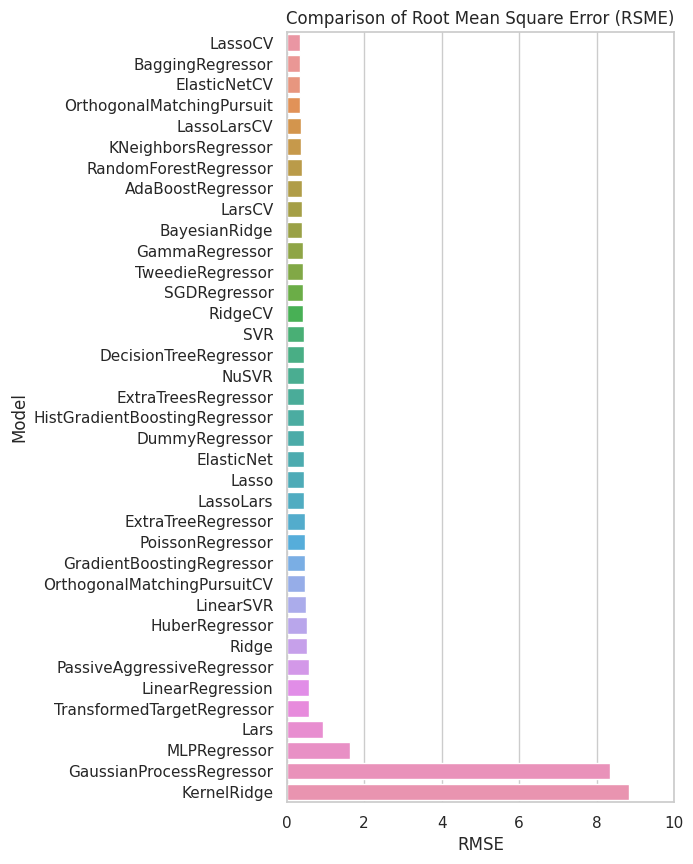

In [111]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
sns.barplot(y=predictions_kat5.index, x="RMSE", data=predictions_kat5)
plt.title("Comparison of Root Mean Square Error (RSME)")
plt.xlim(0, 10)

In [112]:
# Build the Regression Model based on the one with best overall performance (finetuning the 3 best models
# from above)
# GridSearch for LassoCV will pick best params based on R^2 as the default
np.random.seed(100)
random_forest = LassoCV()

param_distributions = {"n_alphas": [num for num in range(2, 11)]}
search_kat5 = GridSearchCV(random_forest, param_distributions).fit(X_kat5_train, Y_kat5_train)
search_kat5.best_params_

{'n_alphas': 9}

In [113]:
# Find the r2 value using our hyperparamater-tuned model
r2_kat5 = search_kat5.score(X_kat5_test, Y_kat5_test)
r2_kat5

0.2851951527355704

We took the best R squared value out of the lazy regressor and our own hyperparameter-tuned models. Lazy Regressor tunes hyperparameters differently than a GridSearch, so we thought trying both methods would yield the best model. In the case of KAT5, the lazy regressor LassoCV achieved an R sqaured value of 0.3964803208, whearas own our own LassoCV only achieve an r squared of 0.2851951527355704. Thus, we will use Lazy Regressor's model to predict how effect a given chemical is at inhibiting KAT5 in our website.

In [115]:
# Get prediction values from the test dataset
Y_kat5_pred = search_kat5.predict(X_kat5_test)

<function matplotlib.pyplot.show(close=None, block=None)>

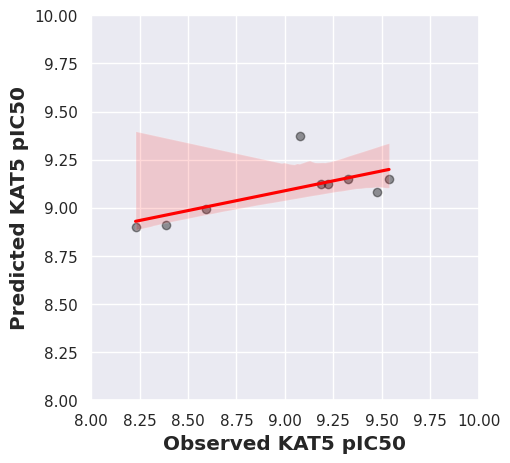

In [117]:
# Scatter Plot of Experimental vs Predicted pIC50 Values
#sns.set(color_codes=True)
sns.color_palette("flare", as_cmap=True)
sns.set_style("darkgrid")

ax = sns.regplot(x=Y_kat5_test, y=Y_kat5_pred, scatter_kws={'alpha':0.4, "color": "black"}, 
                 line_kws={"color": "red"})
ax.set_xlabel('Observed KAT5 pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted KAT5 pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(8, 10)
ax.set_ylim(8, 10)
ax.figure.set_size_inches(5, 5)
plt.show

In [118]:
# Save model as pickle file, to be used in the website
pickle.dump(search_kat5.best_estimator_, open('CCR5_model.pkl', 'wb'))

## Protease Fingerprints

In [119]:
# Extract input features
X_protease = df_protease.drop('pIC50', axis=1)
X_protease

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# Extract output features
Y_protease = df_protease.pIC50
Y_protease

0    9.00
1    8.69
2    9.22
3    9.22
4    9.54
5    8.85
6    8.89
7    8.87
8    8.38
9    8.28
10   8.54
11   8.48
12   8.59
13   8.42
14   8.67
15   8.44
16   9.05
17   9.02
18   8.52
19   9.30
20   9.17
21   9.04
22   8.31
23   9.06
24   8.23
25   9.22
26   9.36
27   9.33
28   9.29
29   9.03
30   8.97
31   9.00
32   9.24
33   9.25
34   9.47
35   9.21
36   9.08
37   9.33
38   9.21
39   9.43
40   9.19
41   9.29
42   8.97
43   9.24
Name: pIC50, dtype: float64

In [121]:
# Check X Dimension
X_protease.shape

(44, 881)

In [122]:
# Check Y Dimension
Y_protease.shape

(44,)

In [123]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_protease = selection.fit_transform(X_protease)

In [124]:
# Check X Dimension after the removal of low variance features
X_protease.shape

(44, 97)

In [125]:
# Split the model into 80-20 format
X_protease_train, X_protease_test, Y_protease_train, Y_protease_test = train_test_split(X_protease, Y_protease, 
                                                                       test_size=0.2, random_state=42)

In [126]:
# Check Training Dimension
X_protease_train.shape, Y_protease_train.shape

((35, 97), (35,))

In [127]:
# Check Testing Dimension
X_protease_test.shape, Y_protease_test.shape

((9, 97), (9,))

In [128]:
# Run the training and testing sets through the lazypredict to find the best regression model
models_protease, predictions_protease = clf.fit(X_protease_train, X_protease_test, 
                                                Y_protease_train, Y_protease_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)
  5%|▌         | 2/39 [00:00<00:02, 18.25it/s]{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4718198752039643, 'Adjusted R-Squared': 1.0474768651502055, 'RMSE': 0.3292554304629438, 'Time taken': 0.07833456993103027}
{'Model': 'BaggingRegressor', 'R-Squared': 0.4475962682495158, 'Adjusted R-Squared': 1.0496542680225154, 'RMSE': 0.33672101436632496, 'Time taken': 0.03107166290283203}
{'Model': 'BayesianRidge', 'R-Squared': 0.25330236452191834, 'Adjusted R-Squared': 1.0671188885822995, 'RMSE': 0.39148426150955484, 'Time taken': 0.04692673683166504}
 10%|█         | 4/39 [00:00<00:02, 15.32it/s]{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.4954569902926551, 'Adjusted R-Squared': 1.0453521806478512, 'RMSE': 0.32180368721418556, 'Time taken': 0.09712100028991699}
{'Model': 'DummyRegressor', 'R-Squared': -0.006586014222419889, 'Adjusted R-Squared': 1.090479641727858, 'RMSE': 0.4545350364372194, 'Time taken': 0.0146095752716064

In [129]:
# Performance table of the test set (20% subset) based on training data (80% subset)
predictions_protease = predictions_protease.iloc[::-1][['R-Squared', 'RMSE']]
predictions_protease

,R-Squared,RMSE
Model,,
RandomForestRegressor,0.51,0.32
LassoCV,0.51,0.32
ExtraTreesRegressor,0.50,0.32
DecisionTreeRegressor,0.50,0.32
LassoLarsCV,0.49,0.32
AdaBoostRegressor,0.47,0.33
ElasticNetCV,0.47,0.33
BaggingRegressor,0.45,0.34
LarsCV,0.42,0.35


(0.0, 1.0)

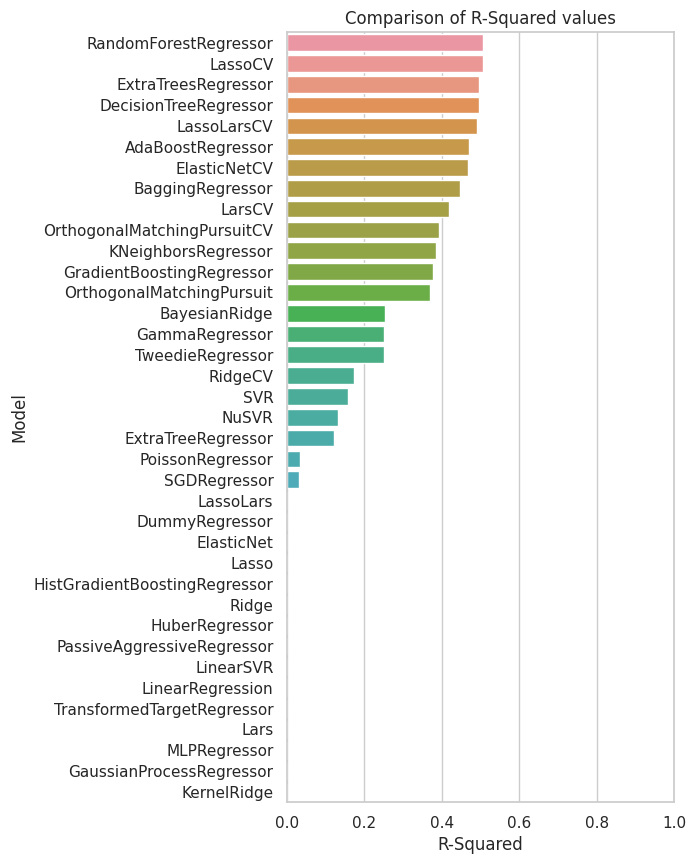

In [130]:
# Bar plot of R-squared values
#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
plt.title("Comparison of R-Squared values")
sns.barplot(y=predictions_protease.index, x="R-Squared", data=predictions_protease)
plt.xlim(0, 1)

(0.0, 10.0)

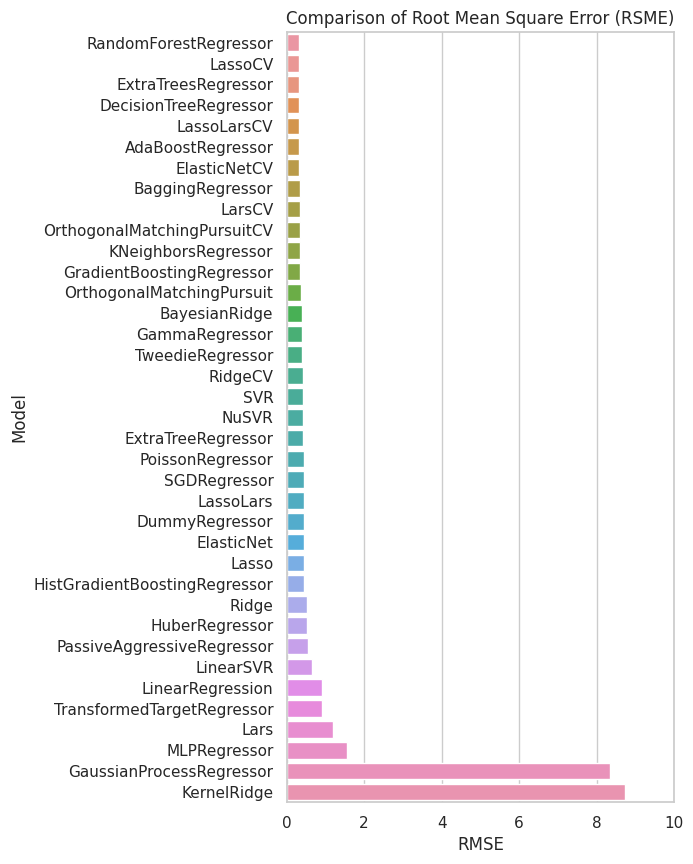

In [131]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
sns.barplot(y=predictions_protease.index, x="RMSE", data=predictions_protease)
plt.title("Comparison of Root Mean Square Error (RSME)")
plt.xlim(0, 10)

In [132]:
# Build the Regression Model based on the one with best overall performance (finetuning the 3 best models
# from above)
np.random.seed(100)
random_forest = RandomForestRegressor()

param_distributions = {"max_depth": [6, 5, 4, 3, None], "min_samples_split": [num for num in range(2, 11)]}
search_protease = HalvingRandomSearchCV(random_forest, param_distributions).fit(X_protease_train, Y_protease_train)
search_protease.best_params_

{'min_samples_split': 10, 'max_depth': 5}

In [134]:
# Find the r2 value using our hyperparamater-tuned model
r2_protease = search_protease.score(X_protease_test, Y_protease_test)
r2_protease

0.439628674764725

We took the best R squared value out of the lazy regressor and our own hyperparameter-tuned models. Lazy Regressor tunes hyperparameters differently than a GridSearch, so we thought trying both methods would yield the best model. In the case of Protease, the lazy regressor RandomForestRegressor achieved an R sqaured value of 0.5067784034, whearas own our own RandomForestRegressor only achieve an R squared of 0.439628674764725. Thus, we will use Lazy Regressor's model to predict how effect a given chemical is at inhibiting Protease in our website.

In [135]:
# Get prediction values from the test dataset
Y_protease_pred = search_protease.predict(X_protease_test)

<function matplotlib.pyplot.show(close=None, block=None)>

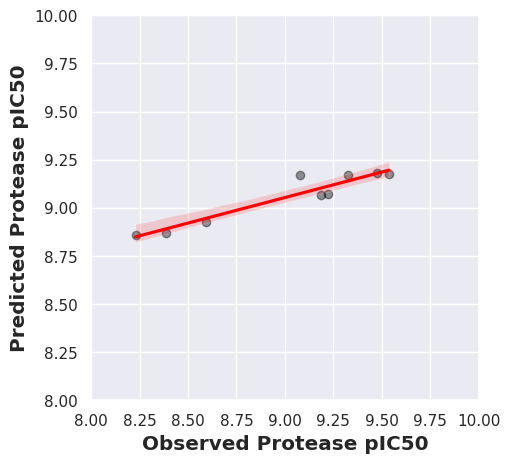

In [137]:
# Scatter Plot of Experimental vs Predicted pIC50 Values
sns.set(color_codes=True)
sns.set_style("darkgrid")

ax = sns.regplot(x=Y_protease_test, y=Y_protease_pred, scatter_kws={'alpha':0.4, "color": "black"}, 
                 line_kws={"color": "red"})
ax.set_xlabel('Observed Protease pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted Protease pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(8, 10)
ax.set_ylim(8, 10)
ax.figure.set_size_inches(5, 5)
plt.show

In [138]:
# Save model as pickle file, to be used in the website
pickle.dump(search_protease.best_estimator_, open('CCR5_model.pkl', 'wb'))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6035b11-f7b4-4c22-8497-513296c81550' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>